Cross Validation 2

size = 121655

test size 4k+

epoch-3

apply sigmoid (prediction probabilities are logits)

groups-9

target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

threshold-tuning = yes

df_2k = df[(df['Rating'] >= 4.0) & (df['Maximum_Installs'] >= 5000)]

accuracy score : F1 score (micro) and ROC_AUC score

## 1. Setup

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers

--- reconnect --

In [ ]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


## 2. Load Dataset

In [ ]:
## uploading csv files on drive (to avoid uploading on colab in every session)

from google.colab import drive
drive.mount("/content/drive/")

## drive path
train_path = "/content/drive/MyDrive/MetadataCSV/data_121655/CV_df_train_2.csv"
val_path = "/content/drive/MyDrive/MetadataCSV/data_121655/CV_df_val_2.csv"
test_path = "/content/drive/MyDrive/MetadataCSV/test_dataset.csv"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path) 
df_test = pd.read_csv(test_path)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(97324, 23)
(24331, 23)
(4624, 23)


In [ ]:
df_train = df_train.sample(n=85000)
print(df_train.shape)

(85000, 23)


In [ ]:
#np.save("/content/drive/MyDrive/Result_XLNet/dummy.csv", df_test)

In [ ]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Contacts,SMS,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length
72973,K.C.S.E Chemistry revision - notes and practicals,com.chemistryrevision.topicals,Education,4.2,50649,False,This is a chemistry that offers resources in c...,https://www.freeprivacypolicy.com/privacy/view...,0,0,...,0,0,0,0,0,0,260,this is a chemistry that offers resources in c...,260,51
58354,IM Auto Reply,com.applicationexpress.imautoreply,Communication,4.0,297781,False,Are you busy? Unavailable? Do you need an tool...,https://1drv.ms/w/s!AiSpfexUtgOWknjHLRJb5-Bs_iKD,0,0,...,1,0,1,0,0,0,2657,are you busy? unavailable? do you need an tool...,2441,481


In [ ]:
target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

In [ ]:
# getting number of nonzeros in each column
df_train[target_list].astype(bool).sum(axis=0)

Camera        14299
Location      14211
Microphone     7678
Contacts       9150
Storage       42053
Phone         13126
SMS             276
Call_Log        178
Calendar       1563
dtype: int64

In [ ]:
df_val[target_list].astype(bool).sum(axis=0)

Camera         4116
Location       4042
Microphone     2220
Contacts       2644
Storage       12012
Phone          3798
SMS             102
Call_Log         65
Calendar        466
dtype: int64

In [ ]:
df_test[target_list].astype(bool).sum(axis=0)

Camera         745
Location       716
Microphone     436
Contacts       500
Storage       2402
Phone          652
SMS             11
Call_Log         6
Calendar        90
dtype: int64

## 3. XLNet Tokenizer - Preprocess Data

### 3.1. Tokenize

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
train_text_list = df_train['Clean_Description'].values
val_text_list = df_val['Clean_Description'].values
test_text_list = df_test['Clean_Description'].values

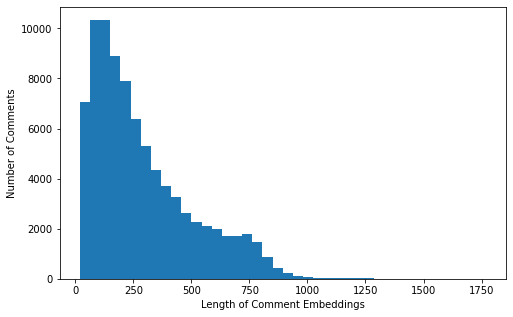

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

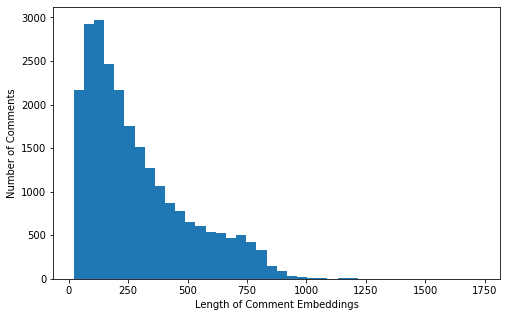

In [ ]:
plot_sentence_embeddings_length(val_text_list, tokenizer)

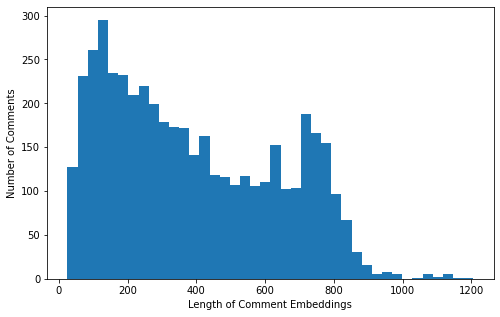

In [ ]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[   52,    27,    24, ...,     0,     0,     0],
       [   41,    44,  3919, ...,  7693,     4,     3],
       [ 4624,    73,  1899, ...,     0,     0,     0],
       ...,
       [ 3134,  2179, 10605, ...,     0,     0,     0],
       [   17,  7485,   267, ...,    28,     4,     3],
       [ 3391,   894,   633, ...,     0,     0,     0]])

In [ ]:
# create input id tokens
val_input_ids = tokenize_inputs(val_text_list, tokenizer, num_embeddings=250)
val_input_ids

array([[   52,  5523,    27, ...,   459,     4,     3],
       [   18,  1848,    17, ...,  1661,     4,     3],
       [25084,   150,  2721, ...,     0,     0,     0],
       ...,
       [   48,  8729,   162, ...,     0,     0,     0],
       [ 4812,    28,    17, ...,    90,     4,     3],
       [ 1180,    78,    52, ...,    19,     4,     3]])

In [ ]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[  108,    44,    41, ...,     0,     0,     0],
       [ 2039,    40,  8425, ...,     0,     0,     0],
       [   17, 12293,  2686, ...,   177,     4,     3],
       ...,
       [26941,   669,    17, ...,   751,     4,     3],
       [ 1184,  2387,  1603, ...,   181,     4,     3],
       [  113,   108,  4626, ...,  1304,     4,     3]])

### 3.2. Attention Masks

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
#train_attention_masks

In [ ]:
# create attention masks
val_attention_masks = create_attn_masks(val_input_ids)
#val_attention_masks

In [ ]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
#test_attention_masks

In [ ]:
# add input ids and attention masks to the dataframe
df_train["features"] = train_input_ids.tolist()
df_train["masks"] = train_attention_masks

df_val["features"] = val_input_ids.tolist()
df_val["masks"] = val_attention_masks

df_test["features"] = test_input_ids.tolist()
df_test["masks"] = test_attention_masks

In [ ]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
72973,K.C.S.E Chemistry revision - notes and practicals,com.chemistryrevision.topicals,Education,4.2,50649,False,This is a chemistry that offers resources in c...,https://www.freeprivacypolicy.com/privacy/view...,0,0,...,0,0,0,0,260,this is a chemistry that offers resources in c...,260,51,"[52, 27, 24, 10421, 29, 1171, 1485, 25, 10421,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
58354,IM Auto Reply,com.applicationexpress.imautoreply,Communication,4.0,297781,False,Are you busy? Unavailable? Do you need an tool...,https://1drv.ms/w/s!AiSpfexUtgOWknjHLRJb5-Bs_iKD,0,0,...,1,0,0,0,2657,are you busy? unavailable? do you need an tool...,2441,481,"[41, 44, 3919, 82, 17442, 82, 112, 44, 214, 48...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
df_val.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Simple Analog Clock [Widget],net.moemoe.tomorrow.myAnalogClock2,Lifestyle,4.2,1113447,False,"# This app is a WIDGET.\r\nAfter installed, yo...",NaN,0,0,...,0,0,0,0,1772,"this app is a widget. after installed, you nee...",1411,302,"[52, 5523, 27, 24, 22534, 9, 99, 3838, 19, 44,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,RememBear: Password Manager and Secure Wallet,com.remembear.android,Productivity,4.0,103362,False,The beautiful RememBear app is the easiest way...,https://www.remembear.com/privacy-policy,0,1,...,1,0,0,0,2485,the beautiful remembear app is the easiest way...,2304,464,"[18, 1848, 17, 21043, 98, 18127, 5523, 27, 18,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,1,0,0,0,901,if you are a poetry lover and did not find the...,876,191,"[108, 44, 41, 24, 7163, 11139, 21, 190, 50, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,1,0,0,0,302,note from developer force close on froyo . fir...,284,70,"[2039, 40, 8425, 779, 474, 31, 17, 12803, 4333...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [ ]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [ ]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [ ]:
acnet_text_list = df_acnet['Clean_Description'].values

# create input id tokens
acnet_input_ids = tokenize_inputs(acnet_text_list, tokenizer, num_embeddings=250)

# create attention masks
acnet_attention_masks = create_attn_masks(acnet_input_ids)

# add input ids and attention masks to the dataframe
df_acnet["features"] = acnet_input_ids.tolist()
df_acnet["masks"] = acnet_attention_masks

### 3.3. Train, Valid Split

In [ ]:
X_train = df_train["features"].values.tolist() + df_acnet["features"].values.tolist() + df_test["features"].values.tolist()

train_masks = df_train["masks"].values.tolist() + df_acnet["masks"].values.tolist() + df_test["masks"].values.tolist()

label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
Y_train = df_train[label_cols].values.tolist() + df_acnet[label_cols].values.tolist() + df_test[label_cols].values.tolist()

In [ ]:
X_valid = df_val["features"].values.tolist()

valid_masks = df_val["masks"].values.tolist()

label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
Y_valid = df_val[label_cols].values.tolist()

### 3.4. Create Dataloaders

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
# Function for class weights

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

    print(class_series)
    print(class_labels)

    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])
    #print(n_samples)
    #print(n_classes)

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    #return dict(zip(class_labels, class_weights))
    return class_weights

In [ ]:
class_series = np.array(Y_train)
class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
print(class_wt)
class_wt = torch.tensor(class_wt)
print(class_wt)

[0.6623016652480412, 0.6641279845928261, 1.224320180747196, 1.0030077673111881, 0.2246254515307633, 0.7281408964391977, 20.27120908483634, 36.12619047619047, 5.757161828874977]
tensor([ 0.6623,  0.6641,  1.2243,  1.0030,  0.2246,  0.7281, 20.2712, 36.1262,
         5.7572])


## 4. XLNet Fine Tuning

### 4.1. Train our model

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      ##
      #mycode-start
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to(device)
      #mycode-end

      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
     
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

-----------from scratch------------

### 4.2. XLNetForMultiLabelSequenceClassification

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to('cuda')
      loss_fct = BCEWithLogitsLoss(pos_weight=class_wt)
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 4.3. Optimizer & Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### 4.4. Training Loop

In [ ]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_mod5.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.014834066395971686
Valid loss: 0.013090289609839661


Epoch:  33%|███▎      | 1/3 [5:45:04<11:30:09, 20704.59s/it]

Saving model at epoch 0 with validation loss of 0.013090289609839661


Train loss: 0.012262091352422951
Valid loss: 0.01277502838573181


Epoch:  67%|██████▋   | 2/3 [11:31:47<5:46:02, 20762.25s/it]

Saving model at epoch 1 with validation loss of 0.01277502838573181


Train loss: 0.01079240595838929


Epoch: 100%|██████████| 3/3 [17:16:47<00:00, 20735.87s/it]

Valid loss: 0.012899936800640034




Text(0.5, 1.0, 'Loss vs Number of Epochs')

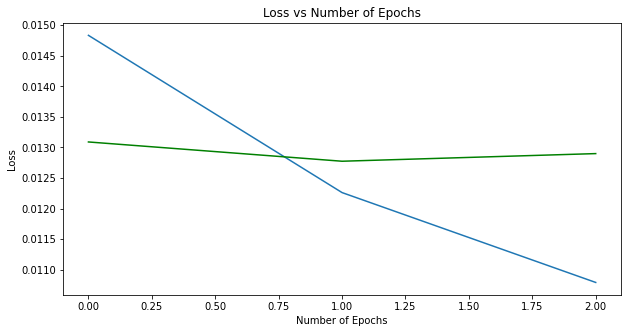

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

------------previous checkpoint------------

In [ ]:
#cwd = os.getcwd()
#model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_mod5.bin")
#model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
#num_epochs=3
#model, train_loss_set, valid_loss_set = train(model=model,\
#                                             num_epochs=num_epochs,\
#                                             optimizer=optimizer,\
#                                             train_dataloader=train_dataloader,\
#                                             valid_dataloader=validation_dataloader,\
#                                             model_save_path=model_save_path,\
#                                             train_loss_set=train_loss_hist,\
#                                             valid_loss_set=valid_loss_hist,\
#                                             lowest_eval_loss=lowest_eval_loss,\
#                                             start_epoch=start_epoch,\
#                                             device="cuda")

Epoch:   0%|          | 0/3 [1:24:15<?, ?it/s]


KeyboardInterrupt: ignored

## 5. Performance On Test Set

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[5.32172481e-03, 2.31269374e-02, 3.67169781e-03, ...,
        3.94266790e-05, 7.88699799e-06, 5.31636062e-04],
       [5.98722184e-03, 7.57088978e-03, 2.32190848e-03, ...,
        2.33218234e-05, 3.66514246e-06, 2.46588315e-04],
       [1.11958764e-01, 2.51996458e-01, 1.50639430e-01, ...,
        4.55886545e-03, 2.90040532e-03, 1.35974750e-01],
       ...,
       [2.55278587e-01, 2.03964740e-01, 3.18886578e-01, ...,
        1.55385048e-03, 4.22523916e-03, 1.63369060e-01],
       [9.59087722e-03, 5.63193500e-01, 7.21188724e-01, ...,
        1.48656356e-04, 2.31301485e-04, 1.42906560e-02],
       [8.19767732e-03, 1.80661809e-02, 2.08752081e-02, ...,
        1.05685038e-04, 7.32119661e-05, 1.53550645e-03]])

In [ ]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_test['P_Camera'] = pred_probs[:,0]
df_test['P_Location'] = pred_probs[:,1]
df_test['P_Microphone'] = pred_probs[:,2]
df_test['P_Contacts'] = pred_probs[:,3]
df_test['P_Storage'] = pred_probs[:,4]
df_test['P_Phone'] = pred_probs[:,5]
df_test['P_SMS'] = pred_probs[:,6]
df_test['P_Call_Log'] = pred_probs[:,7]
df_test['P_Calendar'] = pred_probs[:,8]

In [ ]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.005322,0.023127,0.003672,0.005186,0.165477,0.019198,0.000039,0.000008,0.000532
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.005987,0.007571,0.002322,0.006734,0.080287,0.021095,0.000023,0.000004,0.000247


In [ ]:
test_to_csv = df_test.reset_index()
test_to_csv.head(2)

,index,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.005322,0.023127,0.003672,0.005186,0.165477,0.019198,0.000039,0.000008,0.000532
1,1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.005987,0.007571,0.002322,0.006734,0.080287,0.021095,0.000023,0.000004,0.000247


In [ ]:
true_l = df_test[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_test[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [ ]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [ ]:
np.save("true_labels.npy", true_labels)
np.save("predictions.npy", predictions)

In [ ]:
df_test.to_csv("/content/drive/MyDrive/Result_XLNet/df_test_c2_121.csv")

In [ ]:
predictions

array([[5.32172481e-03, 2.31269374e-02, 3.67169781e-03, ...,
        3.94266790e-05, 7.88699799e-06, 5.31636062e-04],
       [5.98722184e-03, 7.57088978e-03, 2.32190848e-03, ...,
        2.33218234e-05, 3.66514246e-06, 2.46588315e-04],
       [1.11958764e-01, 2.51996458e-01, 1.50639430e-01, ...,
        4.55886545e-03, 2.90040532e-03, 1.35974750e-01],
       ...,
       [2.55278587e-01, 2.03964740e-01, 3.18886578e-01, ...,
        1.55385048e-03, 4.22523916e-03, 1.63369060e-01],
       [9.59087722e-03, 5.63193500e-01, 7.21188724e-01, ...,
        1.48656356e-04, 2.31301485e-04, 1.42906560e-02],
       [8.19767732e-03, 1.80661809e-02, 2.08752081e-02, ...,
        1.05685038e-04, 7.32119661e-05, 1.53550645e-03]])

In [ ]:
true_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 6. Threshold Calculation

In [ ]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data simulation
from sklearn.datasets import make_classification     # Create a synthetic dataframe
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.model_selection import train_test_split # Split the dataframe
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

In [ ]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.1574 with F-Score: 0.7406
permission  1
Length of sequence: 10000
Best Threshold: 0.2429 with F-Score: 0.6421
permission  2
Length of sequence: 10000
Best Threshold: 0.2026 with F-Score: 0.7169
permission  3
Length of sequence: 10000
Best Threshold: 0.2175 with F-Score: 0.5865
permission  4
Length of sequence: 10000
Best Threshold: 0.143 with F-Score: 0.8229
permission  5
Length of sequence: 10000
Best Threshold: 0.2196 with F-Score: 0.5752
permission  6
Length of sequence: 10000
Best Threshold: 0.7304 with F-Score: 0.6
permission  7
Length of sequence: 10000
Best Threshold: 0.9218 with F-Score: 0.9231
permission  8
Length of sequence: 10000
Best Threshold: 0.5782 with F-Score: 0.6524
-------------------------------------
optimal threshold tuning for f-score
[0.1574, 0.2429, 0.2026, 0.2175, 0.143, 0.2196, 0.7304, 0.9218, 0.5782]


In [ ]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.0943 with G-Mean: 0.8651
FPR: 0.1121, TPR: 0.843
permission  1
Best Threshold: 0.0876 with G-Mean: 0.8009
FPR: 0.197, TPR: 0.7989
permission  2
Best Threshold: 0.1271 with G-Mean: 0.8933
FPR: 0.0893, TPR: 0.8761
permission  3
Best Threshold: 0.1304 with G-Mean: 0.828
FPR: 0.1516, TPR: 0.808
permission  4
Best Threshold: 0.1906 with G-Mean: 0.8106
FPR: 0.1706, TPR: 0.7923
permission  5
Best Threshold: 0.1433 with G-Mean: 0.8087
FPR: 0.1752, TPR: 0.7929
permission  6
Best Threshold: 0.2236 with G-Mean: 0.9941
FPR: 0.0117, TPR: 1.0
permission  7
Best Threshold: 0.9234 with G-Mean: 0.9999
FPR: 0.0002, TPR: 1.0
permission  8
Best Threshold: 0.2067 with G-Mean: 0.9491
FPR: 0.0787, TPR: 0.9778
-------------------------------------
ROC curve with G-mean threshold tuning
[0.0943, 0.0876, 0.1271, 0.1304, 0.1906, 0.1433, 0.2236, 0.9234, 0.2067]


## 7. Performance Score

In [ ]:
#Fscore micro for different thresholds-

In [ ]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [ ]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f_at_1(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

   
    acc[0] = f1_score(labels[:, 0], preds_th[:, 0])
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1])
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2])
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3])
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4])
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5])
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6])
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7])
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8])

   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [ ]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/F1_CV2_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.7406
  Location  : 0.6421
  Microphone: 0.7169
  Contacts  : 0.5865
  Storage   : 0.8229
  Phone     : 0.5752
  SMS       : 0.6000
  Call_Log  : 0.9231
  Calendar  : 0.6524

  Average F1 score: 0.6955


In [ ]:
#Fscore micro for different thresholds-

In [ ]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [ ]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f1micro_accuracy(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

    acc[0] = f1_score(labels[:, 0], preds_th[:, 0], average='micro')
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1], average='micro')
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2], average='micro')
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3], average='micro')
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4], average='micro')
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5], average='micro')
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6], average='micro')
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7], average='micro')
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8], average='micro')
    
   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [ ]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/F1Mic_CV2_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.9146
  Location  : 0.9014
  Microphone: 0.9440
  Contacts  : 0.8966
  Storage   : 0.8067
  Phone     : 0.8735
  SMS       : 0.9974
  Call_Log  : 0.9998
  Calendar  : 0.9859

  Average F1 (micro) score: 0.9244


In [ ]:
#roc-auc score for different thresholds-

In [ ]:
import numpy as np
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [ ]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import roc_auc_score

def roc_auc(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_roc[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_roc[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_roc[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_roc[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_roc[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_roc[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_roc[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_roc[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_roc[8]


    acc[0] = roc_auc_score(labels[:, 0], preds_th[:, 0])
    acc[1] = roc_auc_score(labels[:, 1], preds_th[:, 1])
    acc[2] = roc_auc_score(labels[:, 2], preds_th[:, 2])
    acc[3] = roc_auc_score(labels[:, 3], preds_th[:, 3])
    acc[4] = roc_auc_score(labels[:, 4], preds_th[:, 4])
    acc[5] = roc_auc_score(labels[:, 5], preds_th[:, 5])
    acc[6] = roc_auc_score(labels[:, 6], preds_th[:, 6])
    acc[7] = roc_auc_score(labels[:, 7], preds_th[:, 7])
    acc[8] = roc_auc_score(labels[:, 8], preds_th[:, 8])
   

    #print(acc)
    return acc

In [ ]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ROC_CV2_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.8647
  Location  : 0.8008
  Microphone: 0.8923
  Contacts  : 0.8272
  Storage   : 0.8106
  Phone     : 0.8089
  SMS       : 0.9941
  Call_Log  : 0.9166
  Calendar  : 0.9440

  Average ROC_AUC score: 0.8732


# ACNET Performance

#### a) Data Preparation

In [ ]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [ ]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [ ]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [ ]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...


In [ ]:
acnet_text_list = df_acnet['Clean_Description'].values

# create input id tokens
acnet_input_ids = tokenize_inputs(acnet_text_list, tokenizer, num_embeddings=250)

# create attention masks
acnet_attention_masks = create_attn_masks(acnet_input_ids)

# add input ids and attention masks to the dataframe
df_acnet["features"] = acnet_input_ids.tolist()
df_acnet["masks"] = acnet_attention_masks

In [ ]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description,features,masks
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...,"[5988, 27, 978, 28, 6073, 31769, 3116, 21, 102...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...,"[52, 5523, 12861, 573, 21584, 23, 4473, 18, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


#### b) Get Predictions

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_acnet, num_labels, device="cuda", batch_size=32)
pred_probs

array([[5.24104852e-03, 6.92828447e-02, 3.18885525e-03, ...,
        8.88914277e-04, 4.77815134e-04, 6.65880600e-03],
       [3.46869260e-01, 2.58548141e-01, 2.82226473e-01, ...,
        9.95976627e-01, 8.83430183e-01, 4.60888207e-01],
       [1.85990182e-03, 1.67397726e-02, 5.74834878e-03, ...,
        4.56910821e-05, 9.58965302e-06, 1.75018795e-04],
       ...,
       [7.19496654e-03, 2.69299950e-02, 1.14043802e-02, ...,
        3.99694173e-03, 3.14758858e-04, 3.46229458e-03],
       [1.30699773e-03, 1.57946087e-02, 6.14976846e-02, ...,
        1.66954178e-05, 5.66757371e-05, 1.31649227e-04],
       [2.12876834e-02, 9.02740434e-02, 1.17011899e-02, ...,
        7.68018141e-02, 2.02168468e-02, 4.25363183e-02]])

In [ ]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_acnet['P_Camera'] = pred_probs[:,0]
df_acnet['P_Location'] = pred_probs[:,1]
df_acnet['P_Microphone'] = pred_probs[:,2]
df_acnet['P_Contacts'] = pred_probs[:,3]
df_acnet['P_Storage'] = pred_probs[:,4]
df_acnet['P_Phone'] = pred_probs[:,5]
df_acnet['P_SMS'] = pred_probs[:,6]
df_acnet['P_Call_Log'] = pred_probs[:,7]
df_acnet['P_Calendar'] = pred_probs[:,8]

In [ ]:
acnet_to_csv = df_acnet.reset_index()
acnet_to_csv.head(2)

,index,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.005241,0.069283,0.003189,0.013749,0.030335,0.011859,0.000889,0.000478,0.006659
1,1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.346869,0.258548,0.282226,0.804975,0.426262,0.472632,0.995977,0.883430,0.460888


In [ ]:
true_l = df_acnet[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_acnet[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [ ]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [ ]:
np.save("acnet_labels.npy", true_labels)
np.save("acnet_predictions.npy", predictions)

#### c) Threshold Calculation

In [ ]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.1429 with F-Score: 0.5245
permission  1
Length of sequence: 10000
Best Threshold: 0.2161 with F-Score: 0.6906
permission  2
Length of sequence: 10000
Best Threshold: 0.1663 with F-Score: 0.6972
permission  3
Length of sequence: 10000
Best Threshold: 0.2587 with F-Score: 0.6898
permission  4
Length of sequence: 10000
Best Threshold: 0.0858 with F-Score: 0.6165
permission  5
Length of sequence: 10000
Best Threshold: 0.32 with F-Score: 0.5631
permission  6
Length of sequence: 10000
Best Threshold: 0.932 with F-Score: 0.8747
permission  7
Length of sequence: 10000
Best Threshold: 0.9699 with F-Score: 0.8333
permission  8
Length of sequence: 10000
Best Threshold: 0.7978 with F-Score: 0.8148
-------------------------------------
optimal threshold tuning for f-score
[0.1429, 0.2161, 0.1663, 0.2587, 0.0858, 0.32, 0.932, 0.9699, 0.7978]


In [ ]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.0862 with G-Mean: 0.7653
FPR: 0.2506, TPR: 0.7817
permission  1
Best Threshold: 0.1748 with G-Mean: 0.8099
FPR: 0.1586, TPR: 0.7796
permission  2
Best Threshold: 0.0873 with G-Mean: 0.8841
FPR: 0.1367, TPR: 0.9054
permission  3
Best Threshold: 0.2435 with G-Mean: 0.7813
FPR: 0.2074, TPR: 0.7701
permission  4
Best Threshold: 0.1607 with G-Mean: 0.6353
FPR: 0.3919, TPR: 0.6638
permission  5
Best Threshold: 0.1085 with G-Mean: 0.8562
FPR: 0.1808, TPR: 0.8947
permission  6
Best Threshold: 0.8049 with G-Mean: 0.9596
FPR: 0.0524, TPR: 0.9717
permission  7
Best Threshold: 0.9292 with G-Mean: 0.9644
FPR: 0.0501, TPR: 0.9792
permission  8
Best Threshold: 0.4557 with G-Mean: 0.9313
FPR: 0.1069, TPR: 0.9712
-------------------------------------
ROC curve with G-mean threshold tuning
[0.0862, 0.1748, 0.0873, 0.2435, 0.1607, 0.1085, 0.8049, 0.9292, 0.4557]


#### d) Accuracy Score

In [ ]:
#Fscore micro for different thresholds-

In [ ]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [ ]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_F1_CV2_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.5245
  Location  : 0.6906
  Microphone: 0.6972
  Contacts  : 0.6898
  Storage   : 0.6165
  Phone     : 0.5631
  SMS       : 0.8747
  Call_Log  : 0.8333
  Calendar  : 0.8148

  Average F1 score: 0.7005


In [ ]:
#Fscore micro for different thresholds-

In [ ]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [ ]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_F1Mic_CV2_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.8218
  Location  : 0.8656
  Microphone: 0.9300
  Contacts  : 0.7914
  Storage   : 0.5495
  Phone     : 0.9364
  SMS       : 0.9611
  Call_Log  : 0.9745
  Calendar  : 0.9752

  Average F1 (micro) score: 0.8673


In [ ]:
#roc-auc score for different thresholds-

In [ ]:
import numpy as np
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [ ]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_ROC_CV2_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.7655
  Location  : 0.8089
  Microphone: 0.8810
  Contacts  : 0.7814
  Storage   : 0.6351
  Phone     : 0.8570
  SMS       : 0.9573
  Call_Log  : 0.9593
  Calendar  : 0.9273

  Average ROC_AUC score: 0.8414
